**Recurrent Neural Networks**

When you are dealing with time-series or spatial/neighbor dependencies, Recurrent Neural Networks is a good choice. RNNs are used in predicting the future, natural language processing, sentiment analysis, autonomous cars, etc. RNNs are very good predicting the next step (next note in a melody, next word in a sentence, next price of a stock).

# Recurrent Neurons

Up to now we have mostly looked at feedforward neural networks, where the activations flow only in one direction, from the input layer to the output layer. 

A recurrent neural network adds connections pointing backward. Singe neuron RNN: 

![Neuron inner working](images/Chapter14/image_14_1.png)

At each time step $t$ (frame) recurrent neuron receives the inputs $x(t)$ as well as its own output from the previous time step, $y_{(t–1)}$. The image shows the network unrolling through time.

Below is the RNN with multiple neurons. 

![Neuron inner working](images/Chapter14/image_14_2.png)

Each recurrent neuron weight $W_x$ for inputs x(t) and the weight $W_y$ for the outputs of the previous time step, $y_{(t–1)}$.  Below is the output of a single neuron (b is the bias term and $\phi(\cdot)$ is the activation function, e.g., ReLU1):
$$y_{(t)} = \phi(x_{(t)}^T \cdot W_x + y_{(t-1)}^T \cdot W_y + b)$$
For the whole layer of neurons we can use vectorized form:
$$Y_{(t)} = \phi(X_{(t)} \cdot W_x + Y_{(t-1)} \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b)$$
with $W = [W_x , W_y]$

* $Y_{(t)}$ is a $m \times n_{neurons}$ matrix with layer’s outputs at step $t$ for each instance in the mini-batch.$m$ is the number of instances in the mini-batch, and $n_{neurons}$ is the number of neurons.
* $X_{(t)}$ is an $m \times n_{inputs}$ matrix containing the inputs for all instances ($n_{inputs}$ is the number of input features).
* $W_x$ is an $n_{inputs} \times n_{neurons}$ matrix with connection weights for the inputs of the current time step.
* $W_y$ is an $n_{neurons} \times n_{neurons}$ matrix with connection weights for the outputs of the previous time step.
* $W$ is the concatenated matrix of $W_x$ and $W_y$ with the shape $(n_{inputs} + n_{neurons}) \times n_{neurons}$. 
* $b$ is a vector size $n_{neurons}$ with each neuron’s bias term.

$Y_{(t)}$ is a function of $X_{((t)}$ and $Y_{((t–1)}$, which is a function of $X_{((t–1)}$ and $Y_{((t–2)}$,  and so on.

This makes $Y_{((t)}$ a function of all the inputs since time $t = 0$ (that is, $X_{((0)}$, $X_{((1)}$, …, $X_{((t))}$. 

At the first time step, $t = 0$, there are no previous outputs, so they are typically assumed to be all zeros.

# Memory cells

The output of a recurrent neuron at time step $t$ forms a memory from a function of all the inputs from previous time steps.
Network preserves some infromation from previous steps (memory cells).
$$h_{(t)} = f(h_{(t-1)}, x_{(t)})$$

![Neuron inner working](images/Chapter14/image_14_3.png)

# Input and Output Sequences

* An RNN can simultaneously take a sequence of inputs and produce a sequence of outputs (top left). This is useful in predicting times series. 

* RNN can be fed a sequence of inputs, and ignore all outputs except for the last one (top-right). This is useful when updating a score, for example a sentiment score (from –1 [hate] to +1 [love]).

* RNN can work with  a single input at the first time step and zeros for all other time steps (bottom-left). This is a vector-to-sequence network. Input could be an image, and the output could be a caption for that image.

* Sequence-to-vector network (encoder), followed by a vector-to-sequence network, called a decoder (bottom-right).  For example, this can be used for translating a sentence from one language to another. We would translate words in another language, You would feed the network a sentence in one language, the encoder would convert this sentence into a single vector representation, and then the decoder would decode this vector into a sentence in another language.

This two-step model, called an Encoder–Decoder, works much better than trying to translate on the fly with a single sequence-to-sequence RNN, since the last words of a sentence can affect the first words of the translation, so you need to wait until you have heard the whole sentence before translating it.


![Neuron inner working](images/Chapter14/image_14_4.png)

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Then of course we will need TensorFlow:

In [2]:
import tensorflow as tf

# Basic RNNs

Very simple RNN model without using any of TensorFlow’s RNN operations.
* Create an RNN composed of a layer of five recurrent neurons
* Use tanh activation function: $tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$
* Assume that the RNN runs over only two time steps
* Take input vectors of size 3 at each time step. 

## Manual RNN

In [3]:
reset_graph()

n_inputs = 3
n_neurons = 5
# two X vectors in two-periods
X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))
# In the first period we don't add Y
Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
# Second period we add Y0=tf.matmul(Y0, Wy)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b) # MATMUL Matrix product of two arrays.

init = tf.global_variables_initializer()

In [4]:
import numpy as np
# X data
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1
# Evaluate Y
with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

Y has 5 neurons for each data point.

In [5]:
print(Y0_val)

[[-0.0664006   0.96257669  0.68105793  0.70918542 -0.89821601]
 [ 0.9977755  -0.71978903 -0.99657607  0.96739239 -0.99989718]
 [ 0.99999774 -0.99898803 -0.99999893  0.99677622 -0.99999988]
 [ 1.         -1.         -1.         -0.99818915  0.99950868]]


In [6]:
print(Y1_val)

[[ 1.         -1.         -1.          0.40200251 -0.99999982]
 [-0.12210419  0.62805265  0.96718431 -0.99371219 -0.2583937 ]
 [ 0.99999827 -0.9999994  -0.9999975  -0.85943305 -0.99998808]
 [ 0.99928284 -0.99999815 -0.99990582  0.98579627 -0.92205757]]


If you have many steps, it is better to use RNN

## Using `static_rnn()`

In [7]:
n_inputs = 3
n_neurons = 5

The _static_rnn()_ function creates an unrolled RNN network by chaining cells. Same model:

In [8]:
reset_graph()
# Create placeholders for X vectors
X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])
# Setup cell with 5 neurons
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
# Merge two cells together in a network with the same weights and bias terms. 
# The function returns final Y1 and all stages of Y
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1],
                                                dtype=tf.float32)
Y0, Y1 = output_seqs

In [9]:
init = tf.global_variables_initializer()

In [10]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [11]:
Y0_val

array([[ 0.30741334, -0.32884315, -0.65428472, -0.93850589,  0.52089024],
       [ 0.99122757, -0.95425409, -0.75180793, -0.99952078,  0.98202348],
       [ 0.99992681, -0.99783254, -0.82473528, -0.9999963 ,  0.99947774],
       [ 0.99677098, -0.68750614,  0.84199691,  0.93039107,  0.8120684 ]], dtype=float32)

In [12]:
Y1_val

array([[ 0.99998885, -0.99976057, -0.0667929 , -0.99998027,  0.99982214],
       [-0.65249431, -0.51520866, -0.37968948, -0.59225941, -0.08968379],
       [ 0.99862397, -0.99715203, -0.03308626, -0.99915659,  0.99329019],
       [ 0.99681675, -0.95981938,  0.39660627, -0.8307606 ,  0.79671973]], dtype=float32)

In [13]:
from tensorflow_graph_in_jupyter import show_graph

In [14]:
show_graph(tf.get_default_graph())

## Packing sequences

In [15]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [16]:
reset_graph()
# takes a single input placeholder of shape [None, n_steps, n_inputs] where the first dimension is the mini-batch size
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
#extracts the list of input sequences for each time step
# list of n_steps tensors of shape [None, n_inputs]. None is the mini-batch size
# we swap the first two dimensions using the transpose() function, so that the time steps are now the first dimension
# Then we extract a Python list of tensors along the first dimension (i.e., one tensor per time step) 
#using the unstack() function
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs,dtype=tf.float32)
# we merge all the output tensors into a single tensor using the stack() function,
# and we swap the first two dimensions to get a final outputs tensor of shape [None, n_steps, n_neurons]
#the first dimension is the mini-batch size.                                             
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [17]:
init = tf.global_variables_initializer()

In [18]:
# Let's feed all mini-batches.
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [19]:
print(outputs_val)
# This is Y0 and Y1

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.94287992 -0.99988687  0.94055814  0.99999851 -0.9999997 ]]

 [[-0.80015349 -0.99218267  0.78177971  0.99710321 -0.99646091]
  [-0.63711601  0.11300927  0.5798437   0.4310559  -0.6371699 ]]

 [[-0.93605185 -0.99983788  0.93088669  0.99998152 -0.99998295]
  [-0.9165386  -0.99456042  0.89605403  0.99987197 -0.99997509]]

 [[ 0.99273688 -0.99819332 -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746338 -0.73191994  0.7827872   0.95256817 -0.97817731]]]


In [20]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])
# Just Y1 -- final step

[[-0.94287992 -0.99988687  0.94055814  0.99999851 -0.9999997 ]
 [-0.63711601  0.11300927  0.5798437   0.4310559  -0.6371699 ]
 [-0.9165386  -0.99456042  0.89605403  0.99987197 -0.99997509]
 [-0.02746338 -0.73191994  0.7827872   0.95256817 -0.97817731]]


## Using `dynamic_rnn()`
Good solution for many steps. `dynamic_rnn()`:
* allows to GPU memory for CPU if needed ( `swap_memory`=True ). 
* Accepts a single tensor for all inputs at every time step (shape [None, n_steps, n_inputs])
* Outputs a single tensor for all outputs at every time step (shape [None, n_steps, n_neurons])
* there is no need to stack, unstack, or transpose.

In [21]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [22]:
reset_graph()
#same
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
# setup basic cell with 5 neurons
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
# build a dynamic network with 2 steps and X data.
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [23]:
init = tf.global_variables_initializer()

In [24]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [25]:
print(outputs_val)

[[[-0.85115266  0.87358344  0.58029109  0.8954789  -0.0557505 ]
  [-0.99999601  0.99999577  0.99818152  1.          0.37679607]]

 [[-0.99832928  0.9992038   0.98071456  0.99998498  0.25192663]
  [-0.70818043 -0.0772338  -0.85227895  0.58453488 -0.78780943]]

 [[-0.99998271  0.99999535  0.99928629  1.          0.51590723]
  [-0.99939561  0.99840951  0.83422637  0.99999976 -0.47325212]]

 [[ 0.87888587  0.07356028  0.97216916  0.99985462 -0.73511678]
  [-0.91345137  0.36009571  0.76248658  0.99817705  0.80141997]]]


In [26]:
show_graph(tf.get_default_graph())

## Setting the sequence lengths

Not all input sequences have the same length. For example, sentences have different lengths. We can fix it by using: `sequence_length` parameter.

In [27]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [28]:
# Placeholder for sequence length
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

In [29]:
init = tf.global_variables_initializer()

In [30]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
# Second X has a length of 1 rather than 2 (there is not second step). 
seq_length_batch = np.array([2, 1, 2, 2])

In [31]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [32]:
print(outputs_val)
#Y1 is missing for second obs. We only have Y0. 

[[[-0.91231883  0.16516446  0.55486548 -0.39159346  0.20846416]
  [-1.          0.95672601  0.99831694  0.99970174  0.96518576]]

 [[-0.99986118  0.6702289   0.97236532  0.66310459  0.74457586]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99999976  0.89679968  0.99862951  0.96475142  0.93662   ]
  [-0.99995261  0.96819532  0.96002865  0.98706263  0.85459226]]

 [[-0.96435434  0.99501586 -0.36150697  0.99833781  0.999497  ]
  [-0.96135861  0.95687622  0.71322882  0.97729224 -0.0958299 ]]]


In [33]:
# In the final output for 2nd obs we use Y0 instead of Y1
print(states_val)

[[-1.          0.95672601  0.99831694  0.99970174  0.96518576]
 [-0.99986118  0.6702289   0.97236532  0.66310459  0.74457586]
 [-0.99995261  0.96819532  0.96002865  0.98706263  0.85459226]
 [-0.96135861  0.95687622  0.71322882  0.97729224 -0.0958299 ]]


## Training a sequence classifier

We will use backpropagation through time (BPTT).


Just like in regular backpropagation, there is a first forward pass through the unrolled network (represented by the dashed arrows); then the output sequence is evaluated using a cost function $C(Y_{(t_{min})},Y_{(t_{min}+1)}, ... ,Y_{(t_{max})})$
$t_{min}$ and $t_{max}$ are first and last steps.

Note that the gradients flow backward through all the outputs used by the cost function, not just through the final output.

![Neuron inner working](images/Chapter14/image_14_5.png)

Let’s train an RNN to classify MNIST images.
A convolutional 卷积 neural network would be better suited for image classification (see Chapter 13), but the data is familiar.

We treat each image as a sequence of 28 rows of 28 pixels each (since each MNIST image is 28 x 28 pixels). 

We will use cells of 150 recurrent neurons, plus a fully connected layer containing 10 neurons (one per class) connected to the output of the last time step, followed by a softmax layer.

![Neuron inner working](images/Chapter14/image_14_6.png)

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.

Construction is similar of DNN. 
Unrolled RNN replaces the hidden layers

Note that the fully connected layer is connected to the states tensor, which contains only the final state of the RNN (i.e., the 28th output). Also note that y is a placeholder for the target classes.

In [34]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001
#placeholders for X and y
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])
# Basic cell
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
# Probabilities
logits = tf.layers.dense(states, n_outputs)
# Cost function
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
# Adam Optimizer for NN
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
# Predict highest probabilities
correct = tf.nn.in_top_k(logits, y, 1)
#Measure accuracy
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [35]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
# Reshape [batch_size, n_steps, n_inputs]
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [36]:
n_epochs = 100
#150 obs in a batch, 100 epochs
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.933333 Test accuracy: 0.9311
1 Train accuracy: 0.966667 Test accuracy: 0.9522
2 Train accuracy: 0.973333 Test accuracy: 0.9587
3 Train accuracy: 0.973333 Test accuracy: 0.9656
4 Train accuracy: 0.98 Test accuracy: 0.9643
5 Train accuracy: 0.986667 Test accuracy: 0.9706
6 Train accuracy: 0.98 Test accuracy: 0.9658
7 Train accuracy: 0.98 Test accuracy: 0.9701
8 Train accuracy: 0.953333 Test accuracy: 0.9672
9 Train accuracy: 0.98 Test accuracy: 0.9724
10 Train accuracy: 0.993333 Test accuracy: 0.9712
11 Train accuracy: 0.966667 Test accuracy: 0.9661
12 Train accuracy: 0.993333 Test accuracy: 0.9744
13 Train accuracy: 0.986667 Test accuracy: 0.9753
14 Train accuracy: 0.973333 Test accuracy: 0.9701
15 Train accuracy: 0.993333 Test accuracy: 0.9706
16 Train accuracy: 0.993333 Test accuracy: 0.9777
17 Train accuracy: 0.973333 Test accuracy: 0.9762
18 Train accuracy: 0.986667 Test accuracy: 0.9741
19 Train accuracy: 0.986667 Test accuracy: 0.9776
20 Train accuracy: 0.98 Te

Farily good, can be optimized further by hyperparameters.

# Multi-layer RNN

Above we estimated a single layer RNN with 28 steps, now we will estimate 3 layers RNN with 28 steps.

In [37]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [38]:
n_neurons = 100
# 3 Layers
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,
                                      activation=tf.nn.relu)
          for layer in range(n_layers)]
# Multi-layer RNN
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [39]:
# add states for all digits
states_concat = tf.concat(axis=1, values=states)
# Probabilities
logits = tf.layers.dense(states_concat, n_outputs)
# Cost function
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
# Max probl
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [40]:
# Just 10 epochs
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.966667 Test accuracy: 0.9414
1 Train accuracy: 0.986667 Test accuracy: 0.9601
2 Train accuracy: 0.94 Test accuracy: 0.9681
3 Train accuracy: 0.96 Test accuracy: 0.9714
4 Train accuracy: 0.973333 Test accuracy: 0.9759
5 Train accuracy: 0.98 Test accuracy: 0.9792
6 Train accuracy: 0.986667 Test accuracy: 0.9741
7 Train accuracy: 0.993333 Test accuracy: 0.9793
8 Train accuracy: 0.986667 Test accuracy: 0.9789
9 Train accuracy: 0.993333 Test accuracy: 0.9835


# Time series

Let's use RNN to predict the next value in a time-series.

RNN with 100 recurrent neurons and 20 steps (training sequence is 20 inputs long). Each input has one feature.

In [41]:
t_min, t_max = 0, 30
resolution = 0.1
# create time series
def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)
# Randomly draw a batch with a lenght of n_steps.
def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


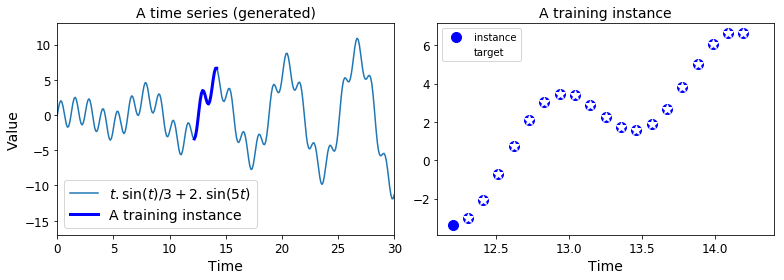

In [42]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [43]:
# Extract a batch with 20 steps
X_batch, y_batch = next_batch(1, n_steps)

In [44]:
np.c_[X_batch[0], y_batch[0]]

array([[ 1.38452097,  2.05081182],
       [ 2.05081182,  2.29742291],
       [ 2.29742291,  2.0465599 ],
       [ 2.0465599 ,  1.34009916],
       [ 1.34009916,  0.32948704],
       [ 0.32948704, -0.76115235],
       [-0.76115235, -1.68967022],
       [-1.68967022, -2.25492776],
       [-2.25492776, -2.34576159],
       [-2.34576159, -1.96789418],
       [-1.96789418, -1.24220428],
       [-1.24220428, -0.37478448],
       [-0.37478448,  0.39387907],
       [ 0.39387907,  0.84815766],
       [ 0.84815766,  0.85045064],
       [ 0.85045064,  0.3752526 ],
       [ 0.3752526 , -0.48422846],
       [-0.48422846, -1.53852738],
       [-1.53852738, -2.54795941],
       [-2.54795941, -3.28097239]])

## Using an `OuputProjectionWrapper`

Let's create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each traiing instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a sigle value:

In [45]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an `OutputProjectionWrapper`.

![Neuron inner working](images/Chapter14/image_14_8.png)

In [46]:
reset_graph()
n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [47]:
# Wrap 100 neurons to make a prediction
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu), output_size=n_outputs)

In [48]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [49]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE cost function
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [50]:
saver = tf.train.Saver()

In [51]:
n_iterations = 1500
batch_size = 50
# Batch size of 50. 
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book

0 	MSE: 11.9673
100 	MSE: 0.525841
200 	MSE: 0.14956
300 	MSE: 0.0727941
400 	MSE: 0.0615854
500 	MSE: 0.0593887
600 	MSE: 0.0547017
700 	MSE: 0.0478491
800 	MSE: 0.0510761
900 	MSE: 0.0472092
1000 	MSE: 0.0470583
1100 	MSE: 0.0478315
1200 	MSE: 0.0408304
1300 	MSE: 0.0470868
1400 	MSE: 0.0417844


In [52]:
with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [53]:
y_pred

array([[[-3.40775299],
        [-2.45754838],
        [-1.10292983],
        [ 0.78156292],
        [ 2.20021749],
        [ 3.12676811],
        [ 3.40377617],
        [ 3.34891534],
        [ 2.87980127],
        [ 2.26593232],
        [ 1.6447463 ],
        [ 1.5210768 ],
        [ 1.89720118],
        [ 2.71590877],
        [ 3.88949037],
        [ 5.14091396],
        [ 6.14206791],
        [ 6.6666708 ],
        [ 6.64101028],
        [ 6.07255268]]], dtype=float32)

Saving figure time_series_pred_plot


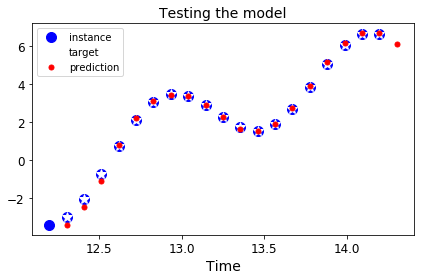

In [54]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

## Without using an `OutputProjectionWrapper`

There is a more efficient solution to using OutputProjectionWrapper

Reshape the RNN outputs from [batch_size, n_steps, n_neurons] to [batch_size * n_steps, n_neurons], then apply a single fully connected layer with the appropriate output size (in our case just 1).

It will result in an output tensor of shape [batch_size * n_steps, n_outputs], and then reshape this tensor to [batch_size, n_steps, n_outputs]. 

![Neuron inner working](images/Chapter14/image_14_10.png)

In [55]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [56]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [57]:
n_outputs = 1
learning_rate = 0.001

In [58]:
# Get output from reshaping the neurons
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [59]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [60]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

0 	MSE: 13.907
100 	MSE: 0.50567
200 	MSE: 0.197359
300 	MSE: 0.101214
400 	MSE: 0.0685015
500 	MSE: 0.0629199
600 	MSE: 0.0551293
700 	MSE: 0.0494365
800 	MSE: 0.0504347
900 	MSE: 0.0482007
1000 	MSE: 0.0480987
1100 	MSE: 0.049825
1200 	MSE: 0.0419125
1300 	MSE: 0.049293
1400 	MSE: 0.0431404


In [61]:
y_pred

array([[[-3.43324828],
        [-2.4594698 ],
        [-1.10811853],
        [ 0.68821532],
        [ 2.11056876],
        [ 3.05851555],
        [ 3.51440883],
        [ 3.35311174],
        [ 2.80801606],
        [ 2.16061521],
        [ 1.66264498],
        [ 1.55789411],
        [ 1.91735375],
        [ 2.72102451],
        [ 3.86678648],
        [ 5.10008287],
        [ 6.09999895],
        [ 6.64809752],
        [ 6.61474228],
        [ 6.022089  ]]], dtype=float32)

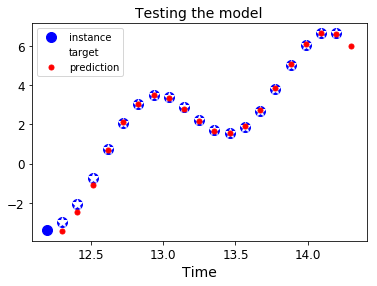

In [62]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Generating a creative new sequence

To generate new sequence we just need use the model to predict the next value, append this predicted value to the sequence, feed the last n_steps values to the model to predict the next value, and so on.

In [63]:
# Load old model
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./my_time_series_model") # not shown

    sequence = [0.] * n_steps
# Predict 300 steps in the future
    for iteration in range(150):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


We are not doing so great in predicting the future.

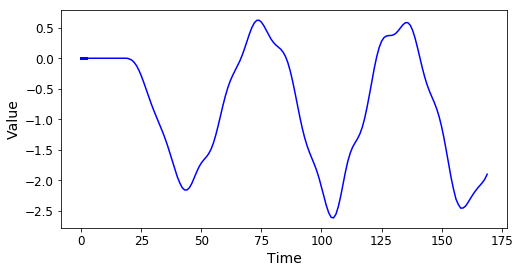

In [64]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

Saving figure time_series_plot


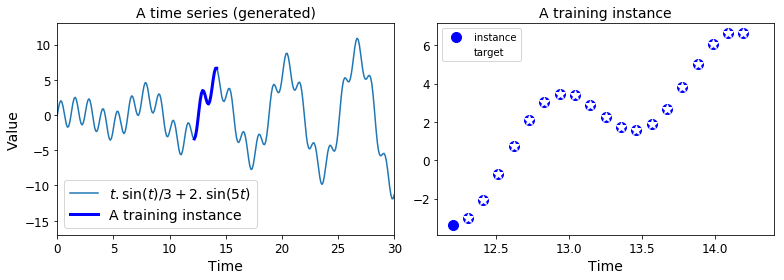

In [65]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

Now let's look at the difference between starting with zero and the actual data point in prediction. 

INFO:tensorflow:Restoring parameters from ./my_time_series_model
Saving figure creative_sequence_plot


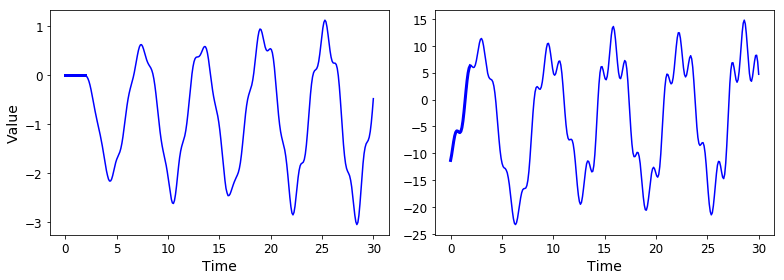

In [66]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")
# Start with zeros
    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])
# Start with actual sequence step
    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
save_fig("creative_sequence_plot")
plt.show()

# Deep RNN

![Neuron inner working](images/Chapter14/image_14_12.jpg)

## MultiRNNCell

In [67]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [68]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [69]:
init = tf.global_variables_initializer()

In [70]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [71]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [72]:
outputs_val.shape

(2, 5, 100)

## Dropout

If you build a very deep RNN, it may end up overfitting the training set. To prevent that, a common technique is to apply dropout. 

You can simply add a dropout layer before or after the RNN as usual, but if you also want to apply dropout between the RNN layers, you need to use a DropoutWrapper. The following code applies dropout to the inputs of each layer in the RNN, dropping each input with a 50% probability:

In [73]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

In [74]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

Note: the `input_keep_prob` parameter can be a placeholder, making it possible to set it to any value you want during training, and to 1.0 during testing (effectively turning dropout off). This is a much more elegant solution than what was recommended in earlier versions of the book (i.e., writing your own wrapper class or having a separate model for training and testing). Thanks to Shen Cheng for bringing this to my attention.

In [75]:
# default keep all
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
# Drop some cell
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
# Final with dropped cells
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [76]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [77]:
n_iterations = 1500
batch_size = 50
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss],
                          feed_dict={X: X_batch, y: y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 100 == 0:                   # not shown in the book
            print(iteration, "Training MSE:", mse) # not shown
    
    saver.save(sess, "./my_dropout_time_series_model")

0 Training MSE: 16.3179
100 Training MSE: 5.04924
200 Training MSE: 3.76201
300 Training MSE: 3.64999
400 Training MSE: 2.9887
500 Training MSE: 3.72573
600 Training MSE: 3.74759
700 Training MSE: 3.72785
800 Training MSE: 3.85187
900 Training MSE: 3.61309
1000 Training MSE: 3.23798
1100 Training MSE: 3.51557
1200 Training MSE: 3.26608
1300 Training MSE: 2.52314
1400 Training MSE: 3.61462


In [78]:
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


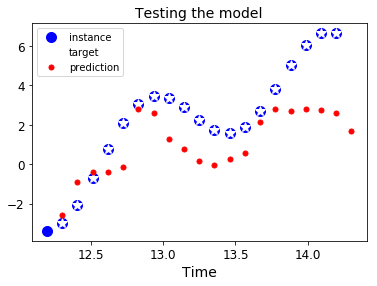

In [79]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

Oops, it seems that Dropout does not help at all in this particular case. :/

# LSTM

The Long Short-Term Memory (LSTM) cell. training will converge faster and it will detect long-term dependencies in the data. In TensorFlow, you can simply use a BasicLSTMCell instead of a BasicRNNCell:

In [80]:
reset_graph()

lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

LSTM cells manage two state vectors, and for performance reasons they are kept separate by default. You can change this default behavior by setting state_is_tuple=False when creating the BasicLSTMCell.
So how does an LSTM cell work?

![Neuron inner working](images/Chapter14/image_14_13.png)

the LSTM cell looks splits in two vectors: $h_{(t)}$ and $c_{(t)}$ (“c” stands for “cell”). You can think of $h_{(t)}$ as the short-term state and $c_{(t)}$ as the long-term state.

* The key idea is that the network can learn what to store in the long-term state, what to throw away, and what to read from it.
* long-term state $c_{(t–1)}$ goes through forget gate dropping some memories and the add memories. 
* Then part of long-term memory is added to short term via output gate and all of it sent along to next cell.
* the current input vector $x_{(t)}$ and the previous short-term state $h_{(t–1)}$ are fed to four different fully connected layers: 
1. The main layer that outputs $g_{(t)}$. It analyzes the current inputs $x_{(t)}$ and the previous (short-term) state $h_{(t–1)}$. In has $tanh$ activation function.
2. The layers $f_{(t)}$,$i_{(t)}$ and $o_{(t)}$ are gate-controllers with logistic activation function (range 0-1). The output is used in multiplication, so 0 closes the gate, and 1 opens it. <br>
    2a. Forget gate $f_{(t)}$ controls which parts of the long-term state should be erased.<br>
    2b. Input gate $i_{(t)}$ controls which parts of $g_{(t)}$ should be added to the long-term state. <br>
    2c. Output gate $o_{(t)}$ controls which parts of $c_{(t)}$ should be read/output at this time step (both to $h_{(t)}$ and $y_{(t)}$. <br>
    

LSTM cell recognizes an important input, stores it in the long-term state, preserves/forgets long-term memory. It is very successful at capturing long-term patterns in time series, long texts, audio recordings, and more. 

$\begin{align}
i_{(t)} &= \sigma (W_{xi}^T \cdot x_{(t)} + W_{hi}^T \cdot h_{(t-1)} + b_i)\\
f_{(t)} &= \sigma (W_{xf}^T \cdot x_{(t)} + W_{hf}^T \cdot h_{(t-1)} + b_f)\\
o_{(t)} &= \sigma (W_{xo}^T \cdot x_{(t)} + W_{ho}^T \cdot h_{(t-1)} + b_o)\\
g_{(t)} &= \tanh(W_{xg}^T \cdot x_{(t)} + W_{hg}^T \cdot h_{(t-1)} + b_g)\\
c_{(t)} &= f_{(t)} \otimes c_{(t-1)} + i_{(t)} \otimes  g_{(t)}\\
y_{(t)} &= h_{(t)} = o_{(t)}  \otimes c_{(t)}\\
\end{align}$

* $W_{xi}^T$, $W_{xf}^T$, $W_{xo}^T$, $W_{xg}^T$ are weight matrices for input vector $x_{(t)}$.
* $W_{hi}^T$, $W_{hf}^T$, $W_{ho}^T$, $W_{hg}^T$ are weight matrices for previous short-term state $h_{(t-1)}$. 
* TensorFlow initializes $b_f$ to a vector full of 1s instead of 0s. This prevents forgetting everything at the beginning of training.

In [81]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])
# Setup LSTM cells
lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
# Use short-term memory for prediction of the last layer
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [82]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.953333 Test accuracy = 0.955
Epoch 1 Train accuracy = 0.98 Test accuracy = 0.9731
Epoch 2 Train accuracy = 0.98 Test accuracy = 0.9747
Epoch 3 Train accuracy = 0.986667 Test accuracy = 0.9798
Epoch 4 Train accuracy = 0.973333 Test accuracy = 0.9855
Epoch 5 Train accuracy = 0.98 Test accuracy = 0.9825
Epoch 6 Train accuracy = 0.993333 Test accuracy = 0.9829
Epoch 7 Train accuracy = 0.986667 Test accuracy = 0.9885
Epoch 8 Train accuracy = 1.0 Test accuracy = 0.9887
Epoch 9 Train accuracy = 1.0 Test accuracy = 0.9855


In [83]:
lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)

In [84]:
gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)

# Embeddings

This section is based on TensorFlow's [Word2Vec tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html).

* Image and audio processing systems work with rich, high-dimensional datasets encoded as vectors of the individual raw pixel-intensities for image data, or e.g. power spectral density coefficients for audio data.
* For recogition task views words as atoms with numeric IDs.
* If words are not connected by similarity (dogs/cat vs dog/cup) the data is very sparse and training is difficult.








# Vector Space Models 

* Vector space models (VSMs) represent (embed) words in a continuous vector space where semantically similar words are mapped to nearby points ('are embedded nearby each other').
* VSMs and other methods depend on the Distributional Hypothesis: *Words that appear in the same contexts share semantic meaning*. Two types of modes:

1. *Count-based methods* compute frequency of word occirance along with its neighbor words in a large text corpus, and then map these frequencies down to a small, dense vector for each word.

2. *Predictive models* predict a word from its neighbors in terms of learned small, dense embedding vectors (considered parameters of the model).

`Word2vec` is a computationally-efficient predictive model for learning word embeddings from raw text. It comes in two flavors: Continuous Bag-of-Words model (CBOW) and Skip-Gram model:

* CBOW predicts target words (e.g. 'mat') from source context words ('the cat sits on the'). It smoothes over a lot of the distributional information by treating an entire context as one observation. CBOW's useful for smaller datasets.

* Skip-gram predicts source context-words from the target words. It treats each context-target pair as a new observation, and does better with large datasets. Skip-gram model will be our focus.

# Scaling up with Noise-Contrastive Training

Neural probabilistic language models are traditionally trained using the maximum likelihood (ML) principle to maximize the probability of the next word  (for "target") given the previous words (for "history") in terms of a softmax function:
$$P(w_t|h) = softmax(score(w_t , h)) = \frac{\exp{score(w_t,h)}}{\sum_{\text{Word w' in Vocab}} \exp{score(w^\prime, h)}}$$

where $score(w_t,h)$ computes the compatibility of word with the context. We train this model by maximizing its log-likelihood on the training set, i.e. by maximizing:
$$J_{ML} = \log P(w_t|h) = score(w_t,h) - \log\bigg(\sum_{\text{Word w' in Vocab}} \exp{score(w^\prime, h)}\bigg)$$

This yields a properly normalized probabilistic model for language modeling.

However this is very expensive, because we need to compute and normalize each probability using the score for all other  words  in the current context, at every training step.

![Neuron inner working](images/Chapter14/softmax-nplm.png)

For feature learning in word2vec we do not need a full probabilistic model. The CBOW and skip-gram models are instead trained using a binary classification objective (logistic regression) to discriminate the real target words from  imaginary (noise) words, in the same context. Maximum likelihood looks like:
$$J_{NEG} = \log Q_{\theta} (D=1\mid w_t ,h) + k \mathop{\mathbb{E}}_{\tilde{w}~P_{noise}}[\log Q_{\theta} (D=0\mid \tilde{w_t} ,h)]$$

where $\log Q_{\theta}$ is the binary logistic regression probability of seeing the word in the context in the dataset, calculated in terms of the learned embedding vectors. In practice we approximate the expectation by drawing  contrastive words from the noise distribution (i.e. we compute Monte Carlo average)

$J_{NEG}$ is maximized when the model assigns high probabilities to the real words, and low probabilities to noise words.
This is called Negative Sampling. The updates it proposes approximate the updates of the softmax function in the limit. But computationally it is especially appealing because computing the loss function now scales only with the number of noise words that we `select()`, and not all words in the `vocabulary()`.  This makes it much faster to train. We will actually make use of the very similar noise-contrastive estimation (NCE) loss.



**the quick brown fox jumped over the lazy dog**

We first form a dataset of words and the contexts in which they appear. 'context' is the window of words to the left and to the right of a target word. Using a window size of 1, we then have the dataset of (context, target) pairs:

**([the, brown], quick), ([quick, fox], brown), ([brown, jumped], fox), ...**

Skip-gram inverts contexts and targets, and tries to predict each context word from its target word, so the task becomes to predict 'the' and 'brown' from 'quick', 'quick' and 'fox' from 'brown', etc. Therefore our dataset becomes:

**(quick, the), (quick, brown), (brown, quick), (brown, fox), ...**

of (input, output) pairs. The objective function is defined over the entire dataset, but we typically optimize this with stochastic gradient descent (SGD) using one example at a time (or a 'minibatch' of batch_size examples, where typically 16 <= batch_size <= 512).

At training step we observe the first training case above, where the goal is to predict the from **quick**. We select num_noise number of noisy (contrastive) examples by drawing from some noise distribution, typically the unigram distribution. 

For simplicity let's say num_noise=1 and we select **sheep** as a noisy example. Next we compute the loss for this pair of observed and noisy examples, i.e. the objective at time step becomes:

$$J_{NEG} = \log Q_{\theta} (D=1\mid \text{the} ,\text{quick}) + k \mathop{\mathbb{E}}_{\tilde{w}~P_{noise}}[\log Q_{\theta} (D=0\mid \text{sheep, quick)}]$$

* The goal is to update to the embedding parameters to improve (maximize) this objective function by deriving the gradient of the loss with respect to the embedding parameters.
* We then perform an update to the embeddings by taking a small step in the direction of the gradient.
* When this process is repeated over the entire training set, this has the effect of 'moving' the embedding vectors around for each word until the model is successful at discriminating real words from noise words.

* We can visualize the learned vectors by projecting them down to 2 dimensions using for instance something like the t-SNE dimensionality reduction technique.
* The vectors capture some general semantic information about words and their relationships to one another.
* Certain directions in the induced vector space specialize towards certain semantic relationships, e.g. male-female, verb tense and even country-capital relationships between words, as illustrated in the figure below:

![Neuron inner working](images/Chapter14/linear-relationships.png) 

## Fetch the data

In [85]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [86]:
words = fetch_words_data()

In [87]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

## Build the dictionary

In [88]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [89]:
# Data is the numeric representation of words
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5234, 3081,   12,    6,  195,    2, 3134,   46,   59]))

In [90]:
words[24], data[24]

('culottes', 0)

## Generate batches

* Generate batches of words of size `batch_size`. 
* Skip windows measures many words to consider left and right
* Number of skips is how many times to reuse an input to generate a label (duplicates).

In [91]:
import random
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [92]:
# Select 8 words.
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [93]:
batch, [vocabulary[word] for word in batch]

(array([3081, 3081,   12,   12,    6,    6,  195,  195]),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [94]:
# Find context for the word **originated**
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[  12],
        [5234],
        [   6],
        [3081],
        [ 195],
        [  12],
        [   6],
        [   2]]),
 ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'a', 'of'])

## Build the model

In [95]:
# Pick 128 words
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
# 100 most commond words
valid_window = 100  # Only pick dev samples in the head of the distribution.
#Draw randomly 16 out of 100 most commond words
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.
learning_rate = 0.01

In [96]:
reset_graph()

# Input data. Create training and validation dataset
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [97]:
vocabulary_size = 50000
# Vector for context:
embedding_size = 150

# Look up embeddings for inputs. 
# Initially 150 values.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [98]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
# Loop up for context
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [99]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Train the model

In [100]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  294.812286377
Nearest to would: viewpoint, lured, rossini, vara, teflon, glaciation, losing, eurasia,
Nearest to on: thatched, falsely, wi, vinegar, euskal, consequentialist, baroness, tallinn,
Nearest to four: hom, rez, siege, translators, khalil, pegged, hellene, ynys,
Nearest to his: pointers, ponty, charged, achieved, rk, blooming, value, juggernaut,
Nearest to often: presses, convenience, arabidopsis, jewry, mapuche, guts, macrinus, implemented,
Nearest to in: furnishing, qi, renderer, mckenna, tuning, illustrate, advances, parser,
Nearest to an: gutierrez, dyess, privations, archaeological, bijection, kon, joh, insemination,
Nearest to eight: malacca, liquidation, davidic, comical, ochre, wild, redman, unconditional,
Nearest to these: pedro, condoned, neck, ssn, supervising, doug, thereto, melton,
Nearest to nine: cocker, struck, dame, tensile, unifies, operetta, develop, opinions,
Nearest to called: paradoxes, wings, krantz, consults, webl

Let's save the final embeddings (of course you can use a TensorFlow `Saver` if you prefer):

In [101]:
np.save("./my_final_embeddings.npy", final_embeddings)

## Plot the embeddings

In [102]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

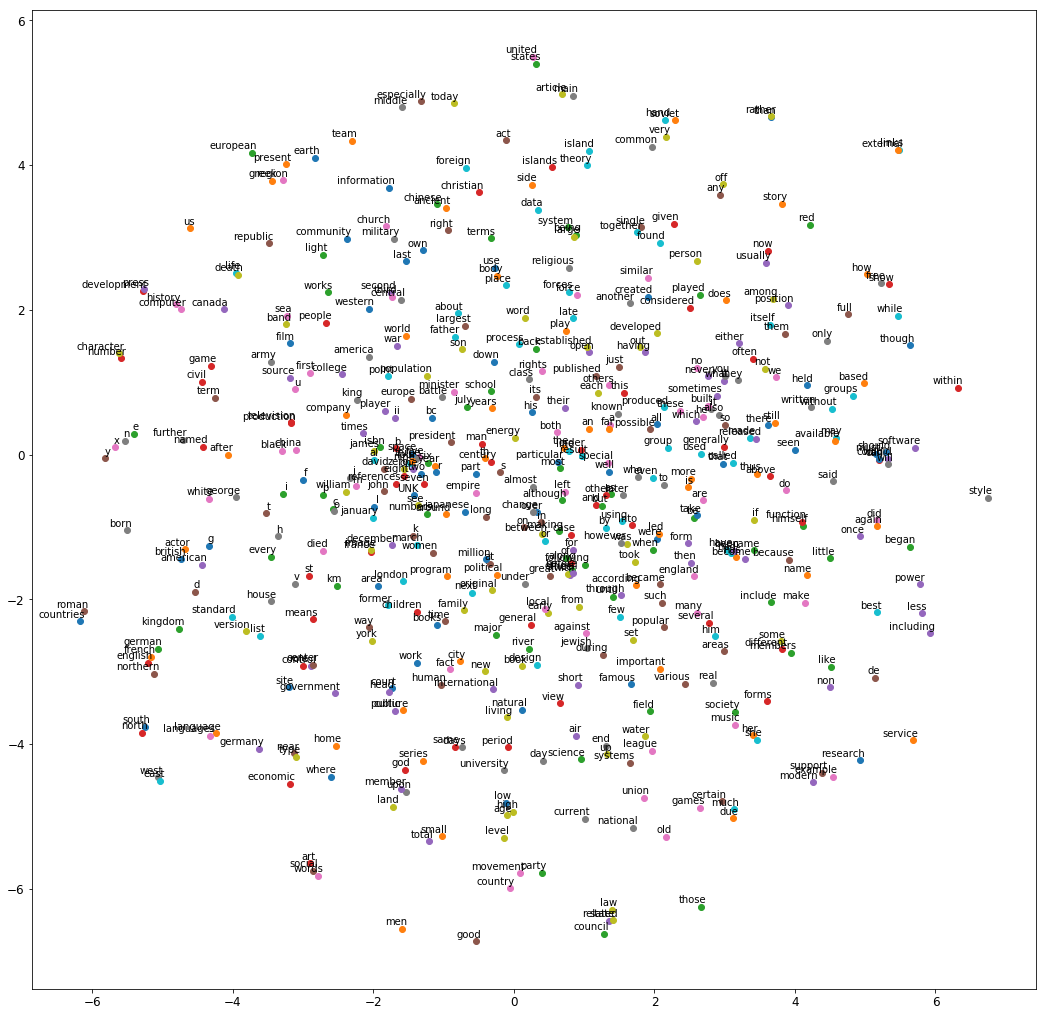

In [103]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)
